In [88]:
import os #Operações com o SO (arquivos)
import json #Leitura/escrita de arquivos JSON
import time #Sleep
import threading #Multithreading
import unicodedata #Normalização de string
import collections #Estrutura de contador e fila
import string #Operações com strings
import re #Expressões regulares
import abc #Classes abstratas
import warnings #Lançamento de warnings
from typing import Optional, Dict, Tuple, Any #Type hints

#import torch #spacy não carrega sem importar antes (??)
#import spacy #Separador em sentenças
import tqdm #Barra de progresso
import groq #API para o Llama 3 70B
#from pyserini.search import SimpleSearcher #Busca nos documentos
import sentence_transformers #Rerankeamento
#import bs4 #Remoção de tags HTML
import numpy as np #Operações com arrays
import matplotlib.pyplot as plt #Plots

In [59]:
if not os.path.isdir("data"):
    os.mkdir("data")

if not os.path.isfile("data\\context_articles.json"):
    !curl -LO https://iirc-dataset.s3.us-west-2.amazonaws.com/context_articles.tar.gz
    !move context_articles.tar.gz data
    !tar -xf data/context_articles.tar.gz
    !move context_articles.json data

if not os.path.isfile("data\\iirc_test.json"):
    !curl -LO https://iirc-dataset.s3.us-west-2.amazonaws.com/iirc_test.json
    !move iirc_test.json data

In [60]:
file = open("data\\context_articles.json", "r")
articles = json.load(file)
file.close()

In [61]:
file = open("data\\iirc_test.json", "r")
test_data = json.load(file)
file.close()

In [62]:
n_question = 50

In [63]:
test_data[0]["questions"][0]

{'answer': {'type': 'span',
  'answer_spans': [{'text': 'sky and thunder god',
    'passage': 'zeus',
    'type': 'answer',
    'start': 83,
    'end': 102}]},
 'question': 'What is Zeus know for in Greek mythology?',
 'context': [{'text': 'he Palici the sons of Zeus',
   'passage': 'main',
   'indices': [684, 710]},
  {'text': 'in Greek mythology', 'passage': 'main', 'indices': [137, 155]},
  {'text': 'Zeus (British English , North American English ; , Zeús ) is the sky and thunder god in ancient Greek religion',
   'passage': 'Zeus',
   'indices': [0, 110]}],
 'question_links': ['Greek mythology', 'Zeus']}

In [64]:
dataset = []

for i in range(len(test_data)):
    item = test_data[i]

    main_passage_name = item["title"]

    #Get the questions
    for q in item["questions"]:
        data = {}
        
        #Get and format the answer
        if q["answer"]["type"] == "span":
            data["answer"] = q["answer"]["answer_spans"][0]["text"]
        elif q["answer"]["type"] == "value":
            data["answer"] = q["answer"]["answer_value"]+" "+q["answer"]["answer_unit"]
        elif  q["answer"]["type"] == "none":
            continue
        elif q["answer"]["type"] == "binary":
            data["answer"] = q["answer"]["answer_value"]
        else:
            raise ValueError
        
        data["question"] = q["question"]

        context = ""
        for context_item in q["context"]:
            passage = context_item["passage"]
            if passage == "main":
                passage = main_passage_name

            context += f"{passage}: {context_item['text']}"
            context += "\n"

        data["context"] = context
        data["context_sentence_count"] = str(len(q["context"]))

        dataset.append(data)

        if len(dataset) == n_question:
            break
    if len(dataset) == n_question:
            break


In [65]:
del test_data, articles

In [ ]:
class GroqInterface:
    '''
    Interface for using the Groq API

    Implements a rate limit control for multi-threading use. 
    '''

    _client :groq.Groq = None 

    LLAMA3_70B = "llama3-70b-8192"

    inference_lock = threading.Lock()
    time_waiter_lock = threading.Lock()
    SINGLE_THREAD = True

    def __init__(self, model:Optional[str]=None, api_key:Optional[str]=None, json_mode:bool=False, system_message:Optional[str]=None, n_retry:int=5):
        '''
        GroqInterface constructor.

        Args:
            model (str, optional): model to use. Llama3 70B is used if None. Default is None
            api_key (str, optional): Groq API key to use, if None will check the environment 'GROQ_API_KEY' variable. Default is None.
            json_mode (bool): if the model need to output in JSON. Default is False.
            system_message (str): the system message to send to the model, if needed. Default is None.
            n_retyr (int): number of times to retry if the model fails (not considering RateLimitError). Default is 5.
        '''
        
        if GroqInterface._client is None:

            if api_key is None:
                api_key = os.environ.get("GROQ_API_KEY")

            if api_key is None:
                raise RuntimeError("API key is not in the environment variables ('GROQ_API_KEY' variable is not set).")

            GroqInterface._client = groq.Groq(api_key=api_key)

        if model is None:
            model = GroqInterface.LLAMA3_70B
        self._model = model

        self._system_message = system_message


        if json_mode:
            self._response_format = {"type": "json_object"}
        else:
            self._response_format = None
        self._json_mode = json_mode

        self._n_retry = n_retry

    def __call__(self, prompt:str) -> str:
        '''
        Generates the model response

        Args:
            prompt (str): prompt to send to the model.

        Returns:
            str: model response. 
        '''
        done = False
        retry_count = 0
        while not done:
            try:
                if not GroqInterface.SINGLE_THREAD:
                    GroqInterface.inference_lock.acquire()
                    GroqInterface.inference_lock.release()

                messages = []
                if self._system_message is not None:
                    messages.append({"role":"system", "content":self._system_message})
                
                messages.append({"role":"user", "content":prompt})

                chat_completion = GroqInterface._client.chat.completions.create(
                        messages=messages,
                        model=self._model,
                        response_format=self._response_format
                    )
                
                done = True
            except groq.RateLimitError as exception: #Wait
                print("ERROR")
                print(exception)
                
                GroqInterface.error = exception
                if not GroqInterface.SINGLE_THREAD:
                    if not GroqInterface.time_waiter_lock.locked():
                        GroqInterface.time_waiter_lock.acquire()
                        GroqInterface.inference_lock.acquire()
                        time.sleep(2)
                        GroqInterface.time_waiter_lock.release()
                        GroqInterface.inference_lock.release()
                else:
                    time.sleep(2)

            except KeyboardInterrupt as e: #Stop the code
                raise e
            except Exception as e: #Retry
                print("ERROR")
                print(e)
                retry_count += 1
                if retry_count >= self._n_retry:
                    raise e

        return chat_completion.choices[0].message.content

In [ ]:
class Tool(abc.ABC):
    '''
    Base class for creating LLM agent tools.
    '''

    @abc.abstractmethod
    def __call__(self, query:Dict[str, str], context:str) -> Dict[str, str]:
        '''
        Execute the tool.

        Args:
            query (str): query for the tool execution.
            context (str): agent context in the tool execution moment.

        Returns:
            Dict[str, str]: tool results.
        '''
        ...

In [ ]:
class QuestionGenerator(Tool, GroqInterface):

    _system_message = '''You are a question generator that outputs in JSON. 
The JSON object must use the schema: {'questions':['str', 'str', ...]}

Please use a valid JSON format.'''

    _base_prompt = '''Generate questions for the given answer:

Answer: {answer}
'''

    def __init__(self, model: Optional[str] = None, api_key: Optional[str] = None):

        super().__init__(model, api_key, True, QuestionGenerator._system_message)

    def __call__(self, query:Dict[str, str], context:str=None) -> Dict[str, str]:
        answer = query["answer"]
        
        prompt = QuestionGenerator._base_prompt.format(answer=answer)


        return json.loads(GroqInterface.__call__(self, prompt=prompt))

In [ ]:
class QuestionComparator(Tool):

    def __init__(self, embedder_model:str="all-MiniLM-L6-v2") -> None:
        self._embedder = sentence_transformers.SentenceTransformer(embedder_model)

    def __call__(self, query: Dict[str, str], context: Optional[str]=None) -> Dict[str, str]:
        query_question = query["query_question"]
        questions = query["questions"]

        q_embedding = self._embedder.encode(query_question, convert_to_tensor=True)
        qi_embeddings = self._embedder.encode(questions, convert_to_tensor=True)
            
        cosine_scores = sentence_transformers.util.cos_sim(q_embedding, qi_embeddings)

        score = cosine_scores.sum().item()
        score /= len(qi_embeddings)

        result = {"score":str(score)}

        return result


In [ ]:
from typing import Dict


class AnswerRelevanceEvaluator(Tool):
    def __init__(self, question_generator=None, question_comparator=None) -> None:
        if question_generator is None:
            question_generator = QuestionGenerator()
        if question_comparator is None:
            question_comparator = QuestionComparator()

        self._question_generator = question_generator
        self._question_comparator = question_comparator
    
    def __call__(self, query: Dict[str, str], context: str=None) -> Dict[str, str]:
        
        if "answer" not in query:
            raise ValueError("Query must have the answer to evaluate (query not have key 'answer').")

        generator_result = self._question_generator(query)

        comparator_query = {"query_question":query["question"], "questions":generator_result["questions"]}
        comparator_result = self._question_comparator(comparator_query)

        return comparator_result

In [ ]:
answer_relevance_evaluator = AnswerRelevanceEvaluator()

In [ ]:
answer_relevance_evaluator(dataset[1])

{'score': '0.19284075498580933'}

In [ ]:
questions = question_generator(dataset[0]["answer"])

In [ ]:
questions

{'questions': ['Who is Zeus in Greek mythology?',
  'What is the god of the sky and thunder in Greek mythology?',
  'What Greek god is associated with the sky and thunder?',
  'Who is the Greek god of the sky and thunder?']}

In [ ]:
class StatementGenerator(Tool, GroqInterface):

    _system_message = '''You are a statement generator that outputs in JSON. 
The JSON object must use the schema: {'statements':['str', 'str', ...]}

Please use a valid JSON format.'''

    _base_prompt = '''Given a question and answer, create one or more statements from each sentence in the given answer:

Question: {question}
Answer: {answer}
'''

    def __init__(self, model: Optional[str] = None, api_key: Optional[str] = None):

        super().__init__(model, api_key, True, StatementGenerator._system_message)

    def __call__(self, query:Dict[str, str], context:str=None) -> Dict[str, str]:
        question = query["question"]
        answer = query["answer"]
        
        prompt = StatementGenerator._base_prompt.format(question=question, answer=answer)


        return json.loads(GroqInterface.__call__(self, prompt=prompt))

In [ ]:
statement_generator = StatementGenerator()

In [ ]:
generator_result = statement_generator(dataset[0])

In [ ]:
generator_result

{'statements': ['Zeus is known as the sky god in Greek mythology.',
  'Zeus is known as the thunder god in Greek mythology.']}

In [ ]:
class StatementContextVerificator(Tool, GroqInterface):

    _system_message = '''You are a statement analist that outputs in JSON. 
The JSON object must use the schema: 
{'analysis':[{'explanation':'str', 'verdict':'bool'}, {'explanation':'str', 'verdict':'bool'}, ...  ]}.

The analysis list must be of same size of the input.

Please use a valid JSON format.'''

    _base_prompt = '''Context: 
{context}

Consider the given context and following statements, then determine whether they are supported by 
the information present in the context. Provide a brief explanation for each statement before arriving at the verdict (true/false). 
Provide a final verdict for each statement in order at the end in the given format. Do not deviate from the specified format.

{statements}
'''

    def __init__(self, model: Optional[str] = None, api_key: Optional[str] = None):

        super().__init__(model, api_key, True, StatementContextVerificator._system_message)

    def __call__(self, query:Dict[str, str], context:str=None) -> Dict[str, str]:
        statements = ""
        
        for statement in query["statements"]:
            statements += "Statement: "+statement+"\n"
        
        prompt = StatementContextVerificator._base_prompt.format(statements=statements, context=query["rag_context"])


        return json.loads(GroqInterface.__call__(self, prompt=prompt))

In [ ]:
statement_context_verificator = StatementContextVerificator()

In [ ]:
query = {"statements": generator_result["statements"], "rag_context":dataset[0]["context"]}
verificator_result = statement_context_verificator(query)

In [ ]:
verificator_result

{'analysis': [{'explanation': 'The context states that Zeus is the sky and thunder god in ancient Greek religion, which aligns with the statement that Zeus is known as the sky god in Greek mythology.',
   'verdict': True},
  {'explanation': 'The context states that Zeus is the sky and thunder god in ancient Greek religion, which aligns with the statement that Zeus is known as the thunder god in Greek mythology.',
   'verdict': True}]}

In [ ]:
supported = 0
total = len(generator_result["statements"])

for analisy in verificator_result["analysis"]:
    supported += analisy["verdict"]

score = supported/total
score

1.0

In [ ]:
class FaithfulnessEvaluator(Tool):
    def __init__(self, statement_generator:StatementGenerator=None, statement_context_verificator:StatementContextVerificator=None) -> None:
        super().__init__()

        if statement_generator is None:
            statement_generator = StatementGenerator()
        if statement_context_verificator is None:
            statement_context_verificator = StatementContextVerificator()

        self._statement_generator = statement_generator
        self._statement_context_verificator = statement_context_verificator

    def __call__(self, query: Dict[str, str], context: str=None) -> Dict[str, str]:   
        generator_result = self._statement_generator(query)

        verificator_query = {"statements": generator_result["statements"], "rag_context":query["context"]}
        verificator_result = self._statement_context_verificator(verificator_query)

        supported = 0
        total = len(generator_result["statements"])

        for analisy in verificator_result["analysis"]:
            supported += analisy["verdict"]

        score = supported/total

        return {"score":str(score)}


In [ ]:
faithfulness_evaluator = FaithfulnessEvaluator()

In [ ]:
faithfulness_evaluator(dataset[0])

{'score': '1.0'}

In [67]:
class SentenceExtractor(Tool, GroqInterface):
    _system_message = '''You are a sentence extractor that outputs in JSON. 
The JSON object must use the schema: {'sentences':['str', 'str', ...]}

Please use a valid JSON format.'''

    _base_prompt = '''Context: 
{context}

Please extract relevant sentences from the provided context that can potentially help answer the following question. 
If no relevant sentences are found, or if you believe the question cannot be answered from the given context, return a object with an empty 'sentences' list.
While extract ing candidate sentences you’re not allowed to make any changes to sentences from given context.

Question: {question}
'''

    def __init__(self, model: Optional[str] = None, api_key: Optional[str] = None):

        super().__init__(model, api_key, True, SentenceExtractor._system_message)

    def __call__(self, query:Dict[str, str], context:str=None) -> Dict[str, str]:
        question = query["question"]
        rag_context = query["rag_context"]
        
        prompt = SentenceExtractor._base_prompt.format(question=question, context=rag_context)

        return json.loads(GroqInterface.__call__(self, prompt=prompt))

In [68]:
sentence_extractor = SentenceExtractor()

In [69]:
extractor_query = {"question": dataset[0]["question"], "rag_context":dataset[0]["context"]}
extractor_result = sentence_extractor(extractor_query)

In [70]:
extractor_result

{'sentences': ['Zeus: Zeus (British English , North American English ; , Zeús ) is the sky and thunder god in ancient Greek religion']}

In [71]:
score = len(extractor_result["sentences"]) / dataset[0]["context_sentence_count"]

score

0.3333333333333333

In [76]:
class ContextRelevanceEvaluator(Tool):
    def __init__(self, sentence_extractor=None) -> None:
        super().__init__()

        if sentence_extractor is None:
            sentence_extractor = SentenceExtractor()

        self._sentence_extractor = sentence_extractor

    def __call__(self, query: Dict[str, str], context: str=None) -> Dict[str, str]:
        extractor_query = {"question": query["question"], "rag_context": query["context"]}
        extractor_result = sentence_extractor(extractor_query)

        score = len(extractor_result["sentences"]) / int(query["context_sentence_count"])

        result = {"score":str(score)}

        return result

In [77]:
context_relevance_evaluator = ContextRelevanceEvaluator()

In [78]:
result = context_relevance_evaluator(dataset[0])

In [79]:
result

{'score': '0.3333333333333333'}

In [81]:
from typing import Dict


class RAGAsEvaluator(Tool):

    def __init__(self, faithfulness_evaluator=None, answer_relevance_evaluator=None, context_relevance_evaluator=None) -> None:
        super().__init__()

        if faithfulness_evaluator is None:
            faithfulness_evaluator = FaithfulnessEvaluator()
        if answer_relevance_evaluator is None:
            answer_relevance_evaluator = AnswerRelevanceEvaluator()
        if context_relevance_evaluator is None:
            context_relevance_evaluator = ContextRelevanceEvaluator()

        self._faithfulness_evaluator = faithfulness_evaluator
        self._answer_relevance_evaluator = answer_relevance_evaluator
        self._context_relevance_evaluator = context_relevance_evaluator
    
    def __call__(self, query: Dict[str, str], context: str=None) -> Dict[str, str]:
        faithfulness_result = self._faithfulness_evaluator(query)
        answer_relevance_result = self._answer_relevance_evaluator(query)
        context_relevance_result = self._context_relevance_evaluator(query)

        result = { 
            "faithfulness" : faithfulness_result["score"],
            "answer_relevance" : answer_relevance_result["score"],
            "context_relevance" : context_relevance_result["score"],
        }

        return result

In [82]:
ragas_evaluator = RAGAsEvaluator()

In [83]:
ragas_result = ragas_evaluator(dataset[0])

In [84]:
ragas_result

{'faithfulness': '1.0',
 'answer_relevance': '0.6503564516703287',
 'context_relevance': '0.3333333333333333'}

In [85]:
evaluations = []

file = open("evaluations.jsonl", "w")

for data in tqdm.tqdm(dataset):
    try:
        evaluation = ragas_evaluator(data)

    except KeyboardInterrupt as e:
        file.close()
        raise e

    except Exception as e:
        print("Evaluation error:", e)

        evaluation = { 
            "faithfulness" : "0",
            "answer_relevance" : "0",
            "context_relevance" : "0",
        }

    evaluations.append(evaluation)

    file.write(json.dumps(evaluation)+"\n")
    file.flush()

file.close()

 52%|█████▏    | 26/50 [04:14<04:55, 12.33s/it]

ERROR
Error code: 400 - {'error': {'message': "Failed to generate JSON. Please adjust your prompt. See 'failed_generation' for more details.", 'type': 'invalid_request_error', 'code': 'json_validate_failed', 'failed_generation': "{'analysis':[{'explanation':'The statement claims that the Perthshire Regiment had been in operation for 69 years when Christopher Harison joined it as a captain in 1849. From the context, we know that the 73rd Regiment of Foot was raised in 1780, and Harison joined in 1849, which means the regiment had been operating for approximately 69 years, matching the statement.', 'verdict':True}]}"}}


 70%|███████   | 35/50 [06:09<03:10, 12.70s/it]

ERROR
Error code: 400 - {'error': {'message': "Failed to generate JSON. Please adjust your prompt. See 'failed_generation' for more details.", 'type': 'invalid_request_error', 'code': 'json_validate_failed', 'failed_generation': '{"analysis":[{"explanation":"The context lists four WHL Championship losses for the Saskatoon Blades, which is the team where Ashton played junior hockey.","verdict":False}]}'}}


 74%|███████▍  | 37/50 [06:38<02:55, 13.49s/it]

ERROR
Error code: 400 - {'error': {'message': "Failed to generate JSON. Please adjust your prompt. See 'failed_generation' for more details.", 'type': 'invalid_request_error', 'code': 'json_validate_failed', 'failed_generation': '{\n"sentences": ["Ron Ashton: Ashton played junior hockey for his hometown Saskatoon Blades of the Western Canadian Hockey League (now WHL), playing his first full season in 1972-73 with future NHL and WHA players Bob Bourne, Dave Lewis and George Pesut,", "Bob Bourne: Robert Glen Bourne (born June 21, 1954)", "Dave Lewis (ice hockey): David Rodney Lewis (born July 3, 1953", "George Pesut: George Matthew Pesut "(Zuti)" (born June 17, 1953"]\n}'}}


100%|██████████| 50/50 [09:24<00:00, 11.29s/it]


In [86]:
file = open("evaluations.json", "w")
json.dump(evaluations, file)
file.close()

In [89]:
faithfulness = np.empty(n_question)
answer_relevance = np.empty(n_question)
context_relevance = np.empty(n_question)

for i in range(n_question):
    faithfulness[i] = evaluations[i]["faithfulness"]
    answer_relevance[i] = evaluations[i]["answer_relevance"]
    context_relevance[i] = evaluations[i]["context_relevance"]


In [100]:
print("Faithfullness ", "Min:", faithfulness.min(), "| Max:", faithfulness.max())
print("Answer Relevance ", "Min:", answer_relevance.min(), "| Max:", answer_relevance.max())
print("Context Relevance ", "Min:", context_relevance.min(), "| Max:", context_relevance.max())

Faithfullness  Min: 0.0 | Max: 1.0
Answer Relevance  Min: 0.026833323140939076 | Max: 0.7692429224650065
Context Relevance  Min: 0.0 | Max: 5.5


In [101]:
np.clip(context_relevance, 0, 1)

array([0.33333333, 1.        , 1.        , 0.        , 0.66666667,
       0.5       , 0.5       , 0.8       , 1.        , 1.        ,
       1.        , 0.5       , 0.5       , 0.5       , 0.        ,
       0.5       , 1.        , 0.66666667, 0.4       , 1.        ,
       0.5       , 1.        , 0.5       , 1.        , 1.        ,
       1.        , 0.5       , 0.5       , 1.        , 0.5       ,
       0.        , 1.        , 0.        , 0.66666667, 1.        ,
       1.        , 0.5       , 0.75      , 0.5       , 0.5       ,
       0.5       , 1.        , 1.        , 0.5       , 0.66666667,
       0.5       , 1.        , 0.66666667, 0.66666667, 0.66666667])

In [102]:
context_relevance = np.clip(context_relevance, 0, 1)

In [109]:
print("Criterion|Score")
print("-|-")
print("Faithfullness|", faithfulness.mean(), "±", faithfulness.std())
print("Answer Relevance|", answer_relevance.mean(), "±", answer_relevance.std())
print("Context Relevance|", context_relevance.mean(), "±", context_relevance.std())

Criterion|Score
-|-
Faithfullness| 0.73 ± 0.43829214001622246
Answer Relevance| 0.24423735859899814 ± 0.14732980886784547
Context Relevance| 0.6689999999999999 ± 0.2985522474282256


Criterion|Score
-|-
Faithfullness| 0.73 ± 0.43829214001622246
Answer Relevance| 0.24423735859899814 ± 0.14732980886784547
Context Relevance| 0.6689999999999999 ± 0.2985522474282256

(array([13.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0., 36.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

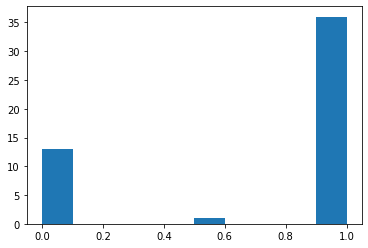

In [104]:
plt.hist(faithfulness)

(array([ 6., 14.,  9.,  9.,  7.,  2.,  1.,  1.,  0.,  1.]),
 array([0.02683332, 0.10107428, 0.17531524, 0.2495562 , 0.32379716,
        0.39803812, 0.47227908, 0.54652004, 0.620761  , 0.69500196,
        0.76924292]),
 <BarContainer object of 10 artists>)

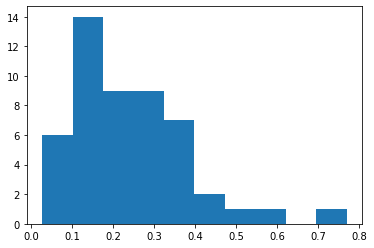

In [105]:
plt.hist(answer_relevance)

In [106]:
context_relevance

array([0.33333333, 1.        , 1.        , 0.        , 0.66666667,
       0.5       , 0.5       , 0.8       , 1.        , 1.        ,
       1.        , 0.5       , 0.5       , 0.5       , 0.        ,
       0.5       , 1.        , 0.66666667, 0.4       , 1.        ,
       0.5       , 1.        , 0.5       , 1.        , 1.        ,
       1.        , 0.5       , 0.5       , 1.        , 0.5       ,
       0.        , 1.        , 0.        , 0.66666667, 1.        ,
       1.        , 0.5       , 0.75      , 0.5       , 0.5       ,
       0.5       , 1.        , 1.        , 0.5       , 0.66666667,
       0.5       , 1.        , 0.66666667, 0.66666667, 0.66666667])

(array([ 4.,  0.,  0.,  1.,  1., 17.,  7.,  1.,  1., 18.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

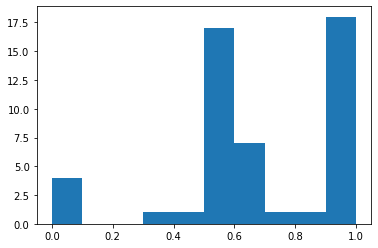

In [107]:
plt.hist(context_relevance)